In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import  cross_val_predict
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [2]:
data = pd.read_csv("loans_2007.csv", low_memory=False)
# There are total 52 columns, and 42538 rows
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          42538 non-null  object 
 1   member_id                   42535 non-null  float64
 2   loan_amnt                   42535 non-null  float64
 3   funded_amnt                 42535 non-null  float64
 4   funded_amnt_inv             42535 non-null  float64
 5   term                        42535 non-null  object 
 6   int_rate                    42535 non-null  object 
 7   installment                 42535 non-null  float64
 8   grade                       42535 non-null  object 
 9   sub_grade                   42535 non-null  object 
 10  emp_title                   39909 non-null  object 
 11  emp_length                  41423 non-null  object 
 12  home_ownership              42535 non-null  object 
 13  annual_inc                  425

In [4]:
data.columns


Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

In [5]:
# We need to apply feature engineering first, we need to eleminate features that doesn't help
# predicting loan status. This would need bit of domain knowledge. 
# For a layman we can say we id, member id, emp title, sub grade, funded amount (as it come after loan)
# late fee, recovery amount also come after loan approval. Hence we need to remove those features, as they will
# just take memory and compute nothing else.

column_2_remove = ['id', 'member_id','funded_amnt',
                   'funded_amnt_inv','sub_grade','emp_title',
                   'issue_d','total_pymnt', 'total_pymnt_inv',
                   'total_rec_prncp','out_prncp', 'out_prncp_inv',
                   'zip_code', 'total_rec_prncp', 'total_rec_int',
                   'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
                   'last_pymnt_d', 'last_pymnt_amnt']
# Columns 'last_credit_pull_d', 'earliest_cr_line', 'title', 'grade', 'addr_state' are part of index hence can't be deleted
data = data.drop(columns=column_2_remove, axis=1)

# Now see data information again
data.info()
# Only 33 column letf, but still we need to continue feature engineering


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   42535 non-null  float64
 1   term                        42535 non-null  object 
 2   int_rate                    42535 non-null  object 
 3   installment                 42535 non-null  float64
 4   grade                       42535 non-null  object 
 5   emp_length                  41423 non-null  object 
 6   home_ownership              42535 non-null  object 
 7   annual_inc                  42531 non-null  float64
 8   verification_status         42535 non-null  object 
 9   loan_status                 42535 non-null  object 
 10  pymnt_plan                  42535 non-null  object 
 11  purpose                     42535 non-null  object 
 12  title                       42522 non-null  object 
 13  addr_state                  425

In [7]:
# Now lets print top 5 rows in data, as there are 33 columns you will not be able to see them on screen
# without scrolling, hence printing 5 columns at a time
for i in range(0,32,5):
   print(data.iloc[:,i:i+5].head())

   loan_amnt        term int_rate  installment grade
0     5000.0   36 months   10.65%       162.87     B
1     2500.0   60 months   15.27%        59.83     C
2     2400.0   36 months   15.96%        84.33     C
3    10000.0   36 months   13.49%       339.31     C
4     3000.0   60 months   12.69%        67.79     B
  emp_length home_ownership  annual_inc verification_status  loan_status
0  10+ years           RENT     24000.0            Verified   Fully Paid
1   < 1 year           RENT     30000.0     Source Verified  Charged Off
2  10+ years           RENT     12252.0        Not Verified   Fully Paid
3  10+ years           RENT     49200.0     Source Verified   Fully Paid
4     1 year           RENT     80000.0     Source Verified      Current
  pymnt_plan         purpose                 title addr_state    dti
0          n     credit_card              Computer         AZ  27.65
1          n             car                  bike         GA   1.00
2          n  small_business  real es

In [8]:
# Observe loan status, there are many categories exists, we are not concerned about all
# We need to tell whether person paid the loan or he default on loan 
data['loan_status'].value_counts()

Fully Paid                                             34085
Charged Off                                             5662
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Current                                                   19
Late (31-120 days)                                         9
In Grace Period                                            8
Late (16-30 days)                                          2
Default                                                    1
Name: loan_status, dtype: int64

In [9]:
### WE ARE ONLY CONCERNED WITH FULLY PAID OR DEFAULT
not_target = ['Current','Late (31-120 days)','In Grace Period','Late (16-30 days)','Default',
              'Does not meet the credit policy. Status:Fully Paid',
              'Does not meet the credit policy. Status:Charged Off']

In [10]:
## NARROWING DOWN OUR TARGET CATEGORIES
data = data[~data.loan_status.isin(not_target)]
print(data['loan_status'].value_counts())
print(data.shape)
mapping = {'Fully Paid':0,'Does not meet the credit policy. Status:Fully Paid':0,'Charged Off':1,'Does not meet the credit policy. Status:Charged Off':1, 'Default':1}
data['loan_status']= data['loan_status'].map(mapping)
print(data['loan_status'].value_counts())

Fully Paid     34085
Charged Off     5662
Name: loan_status, dtype: int64
(39750, 33)
0.0    34085
1.0     5662
Name: loan_status, dtype: int64


In [12]:
for i in range(0,33,5):
  print(data.iloc[:,i:i+5].head())

   loan_amnt        term int_rate  installment grade
0     5000.0   36 months   10.65%       162.87     B
1     2500.0   60 months   15.27%        59.83     C
2     2400.0   36 months   15.96%        84.33     C
3    10000.0   36 months   13.49%       339.31     C
5     5000.0   36 months    7.90%       156.46     A
  emp_length home_ownership  annual_inc verification_status  loan_status
0  10+ years           RENT     24000.0            Verified          0.0
1   < 1 year           RENT     30000.0     Source Verified          1.0
2  10+ years           RENT     12252.0        Not Verified          0.0
3  10+ years           RENT     49200.0     Source Verified          0.0
5    3 years           RENT     36000.0     Source Verified          0.0
  pymnt_plan         purpose                                  title  \
0          n     credit_card                               Computer   
1          n             car                                   bike   
2          n  small_business   

In [13]:
# IDENTIFYING WHICH FEATURE COLUMNS HELP IN MAKING BETTER PREDICTIONS.
# IF FEATURE IS HAVING ONLY 1 UNIQUE VLAUE THAN IT DOESN'T HELP IN PREDICTING ANYTHING
for column in data.columns:
  uniq= data[column].dropna().unique()
  if len(uniq)>=2:
    print(f'multiple unique values {column} {len(uniq)}')
  else:
    data=data.drop(columns=column)
    print(f'only one unique value {column} {uniq}')

multiple unique values loan_amnt 884
multiple unique values term 2
multiple unique values int_rate 371
multiple unique values installment 15386
multiple unique values grade 7
multiple unique values emp_length 11
multiple unique values home_ownership 5
multiple unique values annual_inc 5321
multiple unique values verification_status 3
multiple unique values loan_status 2
only one unique value pymnt_plan ['n']
multiple unique values purpose 14
multiple unique values title 19632
multiple unique values addr_state 50
multiple unique values dti 2867
multiple unique values delinq_2yrs 11
multiple unique values earliest_cr_line 526
multiple unique values inq_last_6mths 9
multiple unique values open_acc 40
multiple unique values pub_rec 5
multiple unique values revol_bal 21724
multiple unique values revol_util 1089
multiple unique values total_acc 82
only one unique value initial_list_status ['f']
multiple unique values last_credit_pull_d 113
only one unique value collections_12_mths_ex_med [0.

In [14]:
# LETS SEE DATA AGAIN, WE HAVE 26 COLUMNS NOW
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 39750 entries, 0 to 42537
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             39747 non-null  float64
 1   term                  39747 non-null  object 
 2   int_rate              39747 non-null  object 
 3   installment           39747 non-null  float64
 4   grade                 39747 non-null  object 
 5   emp_length            38671 non-null  object 
 6   home_ownership        39747 non-null  object 
 7   annual_inc            39747 non-null  float64
 8   verification_status   39747 non-null  object 
 9   loan_status           39747 non-null  float64
 10  purpose               39747 non-null  object 
 11  title                 39736 non-null  object 
 12  addr_state            39747 non-null  object 
 13  dti                   39747 non-null  float64
 14  delinq_2yrs           39747 non-null  float64
 15  earliest_cr_line   

In [16]:
##DROPPING VALUES WITHOUT ANY TARGET VARIABLE INFORMATION
data = data.dropna(subset=['loan_status'])

0.0    41210
1.0        1
Name: tax_liens, dtype: int64

In [15]:
data.info()
data['pub_rec_bankruptcies'].value_counts()
# If you see there are still columns that have null values, lets cleanup all null valued rows from data frame
# Columns are annual_inc, title, delinq_2yrs, earliest_cr_line, inq_last_6mths, open_acc, open_acc, revol_util                

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39750 entries, 0 to 42537
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             39747 non-null  float64
 1   term                  39747 non-null  object 
 2   int_rate              39747 non-null  object 
 3   installment           39747 non-null  float64
 4   grade                 39747 non-null  object 
 5   emp_length            38671 non-null  object 
 6   home_ownership        39747 non-null  object 
 7   annual_inc            39747 non-null  float64
 8   verification_status   39747 non-null  object 
 9   loan_status           39747 non-null  float64
 10  purpose               39747 non-null  object 
 11  title                 39736 non-null  object 
 12  addr_state            39747 non-null  object 
 13  dti                   39747 non-null  float64
 14  delinq_2yrs           39747 non-null  float64
 15  earliest_cr_line   

0.0    37366
1.0     1677
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

In [16]:
# Dropping NA values from remaining columns
data = data.dropna(subset=['emp_length','title','revol_util','last_credit_pull_d'])
# We are also not considering public record of bankruptices
data = data.drop(columns=['pub_rec_bankruptcies'], axis=1)
print(data.isnull().sum())

loan_amnt              0
term                   0
int_rate               0
installment            0
grade                  0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
loan_status            0
purpose                0
title                  0
addr_state             0
dti                    0
delinq_2yrs            0
earliest_cr_line       0
inq_last_6mths         0
open_acc               0
pub_rec                0
revol_bal              0
revol_util             0
total_acc              0
last_credit_pull_d     0
dtype: int64


In [17]:
print(data.dtypes.value_counts())

object     12
float64    11
dtype: int64


In [18]:
## CONTINIOUS FEATURES
float_df = data.select_dtypes(include=['float'])
float_df

,loan_amnt,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc
0,5000.0,162.87,24000.0,0.0,27.65,0.0,1.0,3.0,0.0,13648.0,9.0
1,2500.0,59.83,30000.0,1.0,1.00,0.0,5.0,3.0,0.0,1687.0,4.0
2,2400.0,84.33,12252.0,0.0,8.72,0.0,2.0,2.0,0.0,2956.0,10.0
3,10000.0,339.31,49200.0,0.0,20.00,0.0,1.0,10.0,0.0,5598.0,37.0
5,5000.0,156.46,36000.0,0.0,11.20,0.0,3.0,9.0,0.0,7963.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...
39781,2500.0,78.42,110000.0,0.0,11.33,0.0,0.0,13.0,0.0,7274.0,40.0
39782,8500.0,275.38,18000.0,0.0,6.40,1.0,1.0,6.0,0.0,8847.0,9.0
39783,5000.0,156.84,100000.0,0.0,2.30,0.0,0.0,11.0,0.0,9698.0,20.0
39784,5000.0,155.38,200000.0,0.0,3.72,0.0,0.0,17.0,0.0,85607.0,26.0


In [19]:
##CATEGORICAL FEATURES
object_df = data.select_dtypes(include=['object'])
object_df

,term,int_rate,grade,emp_length,home_ownership,verification_status,purpose,title,addr_state,earliest_cr_line,revol_util,last_credit_pull_d
0,36 months,10.65%,B,10+ years,RENT,Verified,credit_card,Computer,AZ,Jan-1985,83.7%,Dec-2016
1,60 months,15.27%,C,< 1 year,RENT,Source Verified,car,bike,GA,Apr-1999,9.4%,Oct-2016
2,36 months,15.96%,C,10+ years,RENT,Not Verified,small_business,real estate business,IL,Nov-2001,98.5%,Dec-2016
3,36 months,13.49%,C,10+ years,RENT,Source Verified,other,personel,CA,Feb-1996,21%,Apr-2016
5,36 months,7.90%,A,3 years,RENT,Source Verified,wedding,My wedding loan I promise to pay back,AZ,Nov-2004,28.3%,Jan-2016
...,...,...,...,...,...,...,...,...,...,...,...,...
39781,36 months,8.07%,A,4 years,MORTGAGE,Not Verified,home_improvement,Home Improvement,CO,Nov-1990,13.1%,Jun-2010
39782,36 months,10.28%,C,3 years,RENT,Not Verified,credit_card,Retiring credit card debt,NC,Dec-1986,26.9%,Jul-2010
39783,36 months,8.07%,A,< 1 year,MORTGAGE,Not Verified,debt_consolidation,MBA Loan Consolidation,MA,Oct-1998,19.4%,Jun-2007
39784,36 months,7.43%,A,< 1 year,MORTGAGE,Not Verified,other,JAL Loan,MD,Nov-1988,0.7%,Jun-2007


In [22]:
cols = ['home_ownership', 'verification_status', 'emp_length', 'term']
for col in cols:
  print(data[col].value_counts())
  print("---------------------")
  

RENT        18451
MORTGAGE    17226
OWN          2836
OTHER          96
NONE            3
Name: home_ownership, dtype: int64
---------------------
Not Verified       16466
Verified           12354
Source Verified     9792
Name: verification_status, dtype: int64
---------------------
10+ years    8886
< 1 year     4573
2 years      4387
3 years      4090
4 years      3429
5 years      3279
1 year       3236
6 years      2224
7 years      1770
8 years      1480
9 years      1258
Name: emp_length, dtype: int64
---------------------
 36 months    28234
 60 months    10378
Name: term, dtype: int64
---------------------


In [23]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'last_credit_pull_d'],
      dtype='object')

In [24]:
# Drop following column now as they are part of index and now we have completed all our indexed searches
data = data.drop(columns=["last_credit_pull_d", "earliest_cr_line", "title",'grade', "addr_state"], axis=1)

In [25]:
# Correct emp_lenght column to categorical values.
mapping_dict = {
        "10+ years": "experienced",
        "9 years": "experienced",
        "8 years": "experienced",
        "7 years": "experienced",
        "6 years": "intermediate",
        "5 years": "intermediate",
        "4 years": "intermediate",
        "3 years": "beginner",
        "2 years": "beginner",
        "1 year": "beginner",
        "< 1 year": "beginner",
        "n/a": "beginner"
}

In [26]:
data['emp_length']= data['emp_length'].map(mapping_dict)
# Convert Interest Rate column to float from string
data['int_rate']= data['int_rate'].str.rstrip('%').astype("float")
# Convert Revol_util to float from string
data['revol_util']= data['revol_util'].str.rstrip('%').astype("float")
data.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,5000.0,36 months,10.65,162.87,experienced,RENT,24000.0,Verified,0.0,credit_card,27.65,0.0,1.0,3.0,0.0,13648.0,83.7,9.0
1,2500.0,60 months,15.27,59.83,beginner,RENT,30000.0,Source Verified,1.0,car,1.00,0.0,5.0,3.0,0.0,1687.0,9.4,4.0
2,2400.0,36 months,15.96,84.33,experienced,RENT,12252.0,Not Verified,0.0,small_business,8.72,0.0,2.0,2.0,0.0,2956.0,98.5,10.0
3,10000.0,36 months,13.49,339.31,experienced,RENT,49200.0,Source Verified,0.0,other,20.00,0.0,1.0,10.0,0.0,5598.0,21.0,37.0
5,5000.0,36 months,7.90,156.46,beginner,RENT,36000.0,Source Verified,0.0,wedding,11.20,0.0,3.0,9.0,0.0,7963.0,28.3,12.0


In [27]:
##Convert categorical variables to series data 
cat_cols= ["home_ownership", "verification_status", "purpose", "term", 'emp_length']
dummy_df = pd.get_dummies(data[cat_cols])
dummy_df.head()

,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,...,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months,emp_length_beginner,emp_length_experienced,emp_length_intermediate
0,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,1,1,0,0
2,0,0,0,0,1,1,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
3,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,1,0,0,1,0
5,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,1,0,1,0,0


In [28]:
#Merge the above dataframe with data and drop the column for that we have created series data
data = pd.concat([data, dummy_df], axis=1)
data = data.drop(cat_cols, axis=1)


In [30]:
data.info()
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38612 entries, 0 to 39785
Data columns (total 40 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            38612 non-null  float64
 1   int_rate                             38612 non-null  float64
 2   installment                          38612 non-null  float64
 3   annual_inc                           38612 non-null  float64
 4   loan_status                          38612 non-null  float64
 5   dti                                  38612 non-null  float64
 6   delinq_2yrs                          38612 non-null  float64
 7   inq_last_6mths                       38612 non-null  float64
 8   open_acc                             38612 non-null  float64
 9   pub_rec                              38612 non-null  float64
 10  revol_bal                            38612 non-null  float64
 11  revol_util                  

In [31]:
def model_performance(target, predictions):
  fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex=False, sharey=False,figsize=[16,4])
  ax1.bar(x=target.value_counts().index.astype(str), height=target.value_counts().to_list(), data=target, color=['b','r'])

  metric = metrics.confusion_matrix(target,predictions)
  confusion_dataframe = pd.DataFrame(data=metric, index=['Actual_Positive','Actual_Negative'], columns=['Guessed_Positive', 'Guessed_Negative'])
  sns.heatmap(confusion_dataframe, annot=True, fmt="d", cmap="YlGnBu", ax = ax2)

  fpr, tpr, _ = (metrics.roc_curve(target,predictions))
  plt.plot(fpr, tpr)
  

  fpr, tpr, _ = (metrics.roc_curve(target,predictions))
  ax3.plot(fpr, tpr)
  roc_auc = auc(fpr, tpr)
  ax3.plot([0, 1], [0, 1], 'k--', label='AUC = %0.3f'% roc_auc)
  ax3.legend(loc='lower right')
  ax3.plot([0,1],[0,1],'r--')
  ax3.set_xlim([-0.1,1.0])
  ax3.set_ylim([-0.1,1.01])
  ax3.set_ylabel('True Positive Rate')
  ax3.set_xlabel('False Positive Rate')
  plt.tight_layout()
  print(f'Area Under the Curve: {round(roc_auc,2)}')
  plt.show()


In [32]:
features = data.drop(columns=['loan_status'],axis=1)
target = data['loan_status']

Area Under the Curve: 0.5


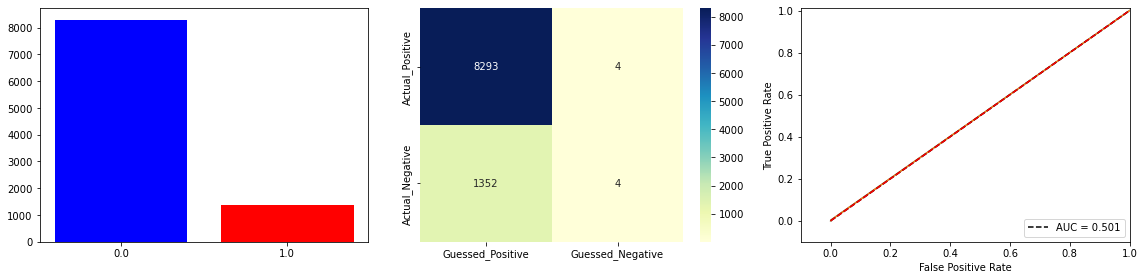

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, random_state = 1)
lr = LogisticRegression(random_state=0, max_iter=100)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
model_performance(y_test, y_pred)

Area Under the Curve: 0.61


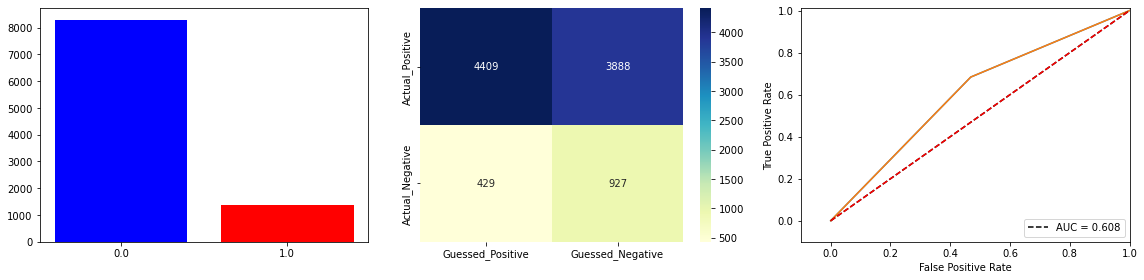

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, random_state = 1)
lr = LogisticRegression(random_state=0, max_iter=150,class_weight="balanced")
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
model_performance(y_test, y_pred)

Area Under the Curve: 0.61


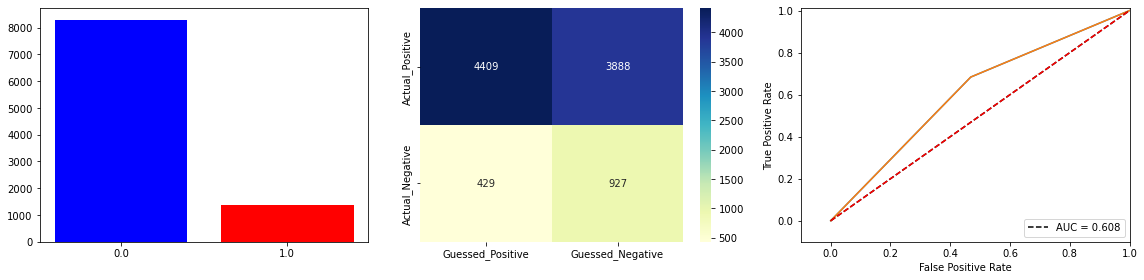

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, random_state = 1)
penalty= {1:10,0:1}
lr_weightp = LogisticRegression(max_iter=150, class_weight=penalty)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
model_performance(y_test, y_pred)

Area Under the Curve: 0.5


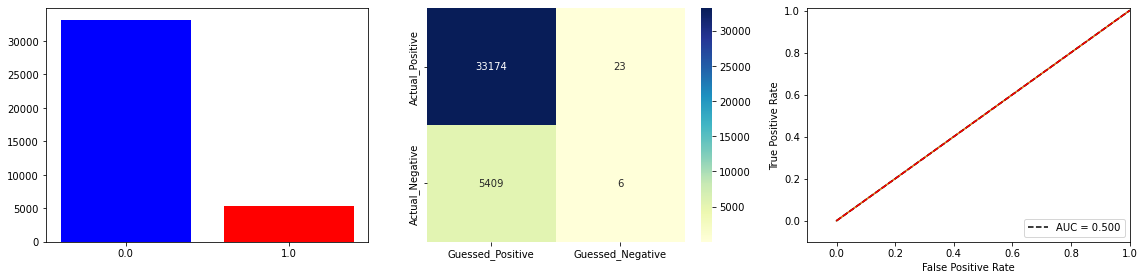


Duration: 2 seconds
------------------------------
Area Under the Curve: 0.59


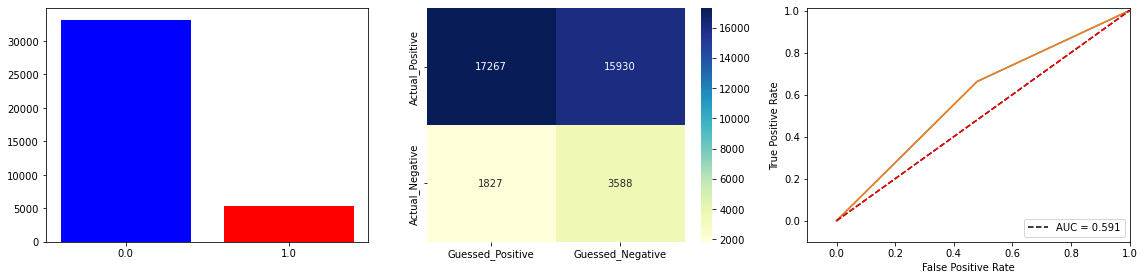


Duration: 2 seconds
-----------------------------
Area Under the Curve: 0.55


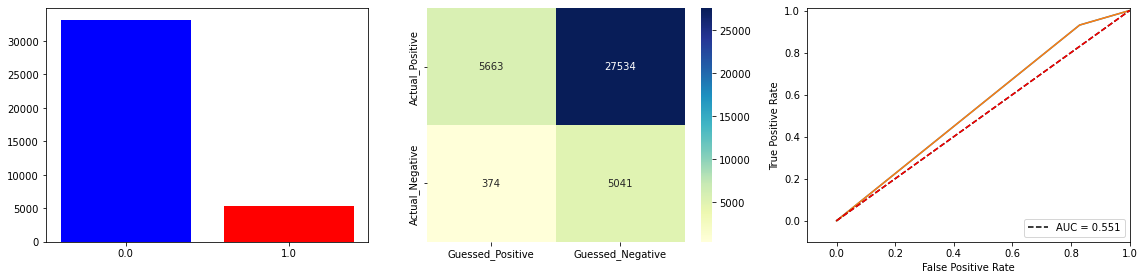


Duration: 2 seconds


In [47]:
#There is other way also, i come across cross_val_predict metho
import time
start_time = time.time()
# Some how this was failing with default max iteration that is 100
lr = LogisticRegression(max_iter=150)
predictions = cross_val_predict(lr, features, target, cv=3)
model_performance(target, predictions)
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

print("------------------------------")
start_time = time.time()
lr = LogisticRegression(max_iter=150, class_weight="balanced")
predictions = cross_val_predict(lr, features, target, cv=3)
model_performance(target, predictions)
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

print("-----------------------------")


start_time = time.time()
penalty= {1:10,0:1}
lr_weightp = LogisticRegression(max_iter=150, class_weight=penalty)
predictionsp = cross_val_predict(lr_weightp, features, target, cv=3)
model_performance(target, predictionsp)
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

In [48]:
# Now lets see if we normalize the data what happen, lets use Min Max Scaler
def normalize(subset):
   continious_columns = subset.select_dtypes(include=['float']).columns
   mm_scaler = preprocessing.MinMaxScaler()
   for col in continious_columns:
     subset[col]= mm_scaler.fit_transform(subset[[col]])
   return subset

In [55]:
lr = LogisticRegression(max_iter=300, class_weight="balanced")
scaled_data = normalize(data)
features_scaled = scaled_data.drop(columns=['loan_status'],axis=1)
target_scaled = scaled_data['loan_status']
features_scaled.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months,emp_length_beginner,emp_length_experienced,emp_length_intermediate
0,0.130435,0.272822,0.114137,0.003336,0.921974,0.0,0.125,0.023810,0.0,0.091237,...,0,0,0,0,0,1,0,0,1,0
1,0.057971,0.513824,0.034230,0.004336,0.033344,0.0,0.625,0.023810,0.0,0.011278,...,0,0,0,0,0,0,1,1,0,0
2,0.055072,0.549817,0.053230,0.001376,0.290764,0.0,0.250,0.000000,0.0,0.019761,...,0,0,1,0,0,1,0,0,1,0
3,0.275362,0.420970,0.250965,0.007538,0.666889,0.0,0.125,0.190476,0.0,0.037423,...,1,0,0,0,0,1,0,0,1,0
5,0.130435,0.129369,0.109166,0.005337,0.373458,0.0,0.375,0.166667,0.0,0.053233,...,0,0,0,0,1,1,0,1,0,0


Area Under the Curve: 0.63


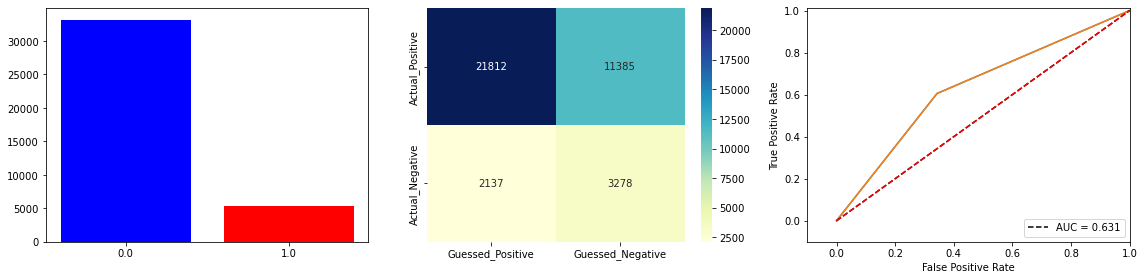

In [56]:
predictionsp = cross_val_predict(lr, features_scaled, target_scaled, cv=3)
model_performance(target_scaled, predictionsp)